# Оптимизация производственный расходов за счёт контроля температуры стали при её легировании

_____

![2_ladle.jpg](https://ltdfoto.ru/images/2023/09/27/2_ladle.jpg)

Металлургический комбинат для оптимизации производственных расходов планирует уменьшить энергопотребление на этапе обработки стали

Сталь обрабатывают в металлическом ковше. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом, а расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, установленными в крышке ковша. Из сплава выводят серу и при помощи добавления примесей корректируют химический состав сплава. Полученную сталь легируют, т.е. изменяют её состав, подавая куски сплава из специального бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

До первого добавления легирующих добавок проводят первый замер температуры стали и её химического анализа. Далее температуру повышают на несколько минут, после чего добавляют к стали легирующие материалы и продувают сплав специальным инертным газом (перемешивают). После всех эти манипуляций снова замеряют температуру сплава.


Необходимо написать модель, которая предскажет конечную температуру стали с ошибкой MAE не больше 6 градусов. Ковш, не подходящий под выделенную температуру, не будет отправлен на доводку, а отбракуется и направится на новую итерацию легирования. Это позволит экономить расходы на электричество за счёт снижения затрат на него путём сокращения неоптимальных производственных процессов, а так же увеличит срок эксплуатации самого ковша.

Модель должна быть интерпретируемой, т.к. комбинат должен понимать влияние состава материала на температуру стали, а значит нейросети для формирования модели не подходят, только лес или бустинги.

_____

![steel_processing.png](https://ltdfoto.ru/images/2023/09/27/steel_processing.png)

имеющиеся в нашем распоряжении данные:

- ```arc.csv``` — данные об электродах
  - *ladle* - данные по ковшу
  - *Arc heating start* - начало нагрева дугой
  - *Arc heating end* - конец нагрева дугой
  - *Active power* - активная мощность
  - *Reactive power* - реактивная мощность
- ```bulk.csv``` — данные о подаче сыпучих материалов (объём)
  - *ladle* - данные по ковшу
  - материалы: Calcium oxide, Magnesium oxide, Aluminum oxide, Silicon oxide, Manganese oxide, Iron oxide, Zirconium oxide, Titanium oxide, Boron oxide, Nickel oxide, Copper oxide, Cobalt oxide, Zinc oxide, Lead oxide, Sulfur oxide
- ```bulk_time.csv``` — данные о времени подачи сыпучих материалов
- ```gas.csv``` — данные о продувке сплава газом
  - *ladle* - данные по ковшу
  - *Ar* - аргон
- ```temp.csv``` — результаты измерения температуры
  - *ladle* - данные по ковшу
  - *Measurement time* - время замера температуры
  - *Temperature* - температура в °C
- ```wire.csv``` — данные о проволочных материалах (объём)
  - *ladle* - данные по ковшу
  - материалы: Ferrosilicon, Ferromanganese, Ferrochrome, Ferrotitanium, Ferronickel, Ferromolybdenum, Ferroboron, Ferroaluminum, Ferrogold
- ```wire_time.csv``` — данные о времени подачи проволочных материалов

_____

в качестве основной контрольной метрики мы рассматриваем ```MAE (Mean Absolute Error)```:

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i-\hat{y}_i|$$

средняя абсолютная ошибка является простой и интерпретируемой метрикой, которая измеряет среднее абсолютное отклонение между предсказанными и фактическими значениями. Она показывает насколько в среднем модель ошибается в предсказании исходных данных. В нашем случае она покажет ошибку (отклоненние) в градусах по Цельсию. Наша цель - добиться значения *MAE* на предсказании не выше 6°C

дополнительной метрикой выступит ```RMSE (Root Mean Squared Error)```:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

корень из среднеквадратической ошибки измеряет среднеквадратичное отклонение между предсказанными и фактическими значениями. Это метрика более чувствительна к выбросам и аномалиям в данных, так как она возводит разницу в квадрат

использование обеих метрик позволяет получить более полное представление о качестве модели и ее способности обобщать данные. Если значения *MAE* и *RMSE* окажутся близки, то можно будет сделать вывод о том, что модель работает хорошо. Если значения *MAE* и *RMSE* сильно разойдутся друг от друга, то это будет указывать на проблемы в модели или самих данных

_____

для реализации цели будем придерживаться следующего плана:
- исследуем имеющиеся в нашем распоряжении данные
- подготовим их к машинному обучению, убрав лишнее и оставили нужное
- переберём несколько алгоритмов машинного обучения, в том числе их попарные ансамбли
- выберем модель, возвращающую наименьшее значение MAE на тренировочной выборке
- проверим выбранную модель на адекватность, сравнив результат её предсказания на отложенной выборке с константной dummy-моделью
- сохраним модель в файл
- подведём итог проделанной работе

_____

импортируем необходимые библиотеки и модули:

In [1]:
import joblib
import itertools
import os

import numpy as np
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from colorama import Fore, Style

from src.functions import (
    get_hist, get_info, plot_distribution, plot_feature_counts, time_check, 
    to_snake_case, return_model_for_shap, evaluate_feature_significance_ols, 
    get_corr_matrix, plot_barh, model_comparison
)
from src.ModelAnalyzer import ModelAnalyzer, GetFinalTable

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
RANDOM_STATE = 555

загружаем данные:

In [2]:
try:
    df_temp = pd.read_csv('datasets/temp.csv')
    df_arc = pd.read_csv('datasets/arc.csv')
    df_bulk = pd.read_csv('datasets/bulk.csv')
    df_bulk_time = pd.read_csv('datasets/bulk_time.csv')
    df_gas = pd.read_csv('datasets/gas.csv')
    df_wire = pd.read_csv('datasets/wire.csv')
    df_wire_time = pd.read_csv('datasets/wire_time.csv')
    df_temp.name, df_arc.name, df_bulk.name, df_bulk_time.name, df_gas.name, df_wire.name, df_wire_time.name = \
        'df_temp', 'df_arc', 'df_bulk', 'df_bulk_time', 'df_gas', 'df_wire', 'df_wire_time'
except FileNotFoundError:
    print('что-то пошло не так, стоит проверить путь к файлам')

отдельно пройдёмся по каждому датасету и посмотрим, с чем дело предстоит иметь:

_____

## данные об электродах:

In [3]:
get_info(df_arc)

таблица df_arc
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ladle              14876 non-null  int64  
 1   Arc heating start  14876 non-null  object 
 2   Arc heating end    14876 non-null  object 
 3   Active power       14876 non-null  float64
 4   Reactive power     14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

размер: (14876, 5)

статистика:


,count,mean,std,min,25%,50%,75%,max
ladle,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Active power,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Reactive power,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


первые/последние строки:


,ladle,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


,ladle,Arc heating start,Arc heating end,Active power,Reactive power
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


пропуски в значениях:

ladle                0
Arc heating start    0
Arc heating end      0
Active power         0
Reactive power       0
dtype: int64

явных дубликатов: 0


- пропусков нет, явных дубликатов нет
- даты формата *object* - поменяем на *datetime*
- в тепло превращается только активная мощность, так что для оптимизации расходов на электроэнергию целесообразно снижать реактивную составляющую, насколько это возможно

In [4]:
df_arc['Arc heating start'] = pd.to_datetime(df_arc['Arc heating start'], format='%Y-%m-%d %H:%M:%S')
df_arc['Arc heating end'] = pd.to_datetime(df_arc['Arc heating end'], format='%Y-%m-%d %H:%M:%S')

равномерно ли распределены даты?

In [5]:
time_check(df_arc['Arc heating start'])
time_check(df_arc['Arc heating end'])

столбец Arc heating start
даты распределены равномерно
начало: 2019-05-03 11:02:14
конец: 2019-09-06 17:24:54
столбец Arc heating end
даты распределены равномерно
начало: 2019-05-03 11:06:02
конец: 2019-09-06 17:26:15


у *Reactive power* нездоровое распределение, большой минус в минимуме, посмотрим, сколько значений < 0:

In [6]:
df_arc[df_arc['Reactive power'] < 0]

,ladle,Arc heating start,Arc heating end,Active power,Reactive power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


одна строчка - выброс. Удалим её и посмотрим на распределение:

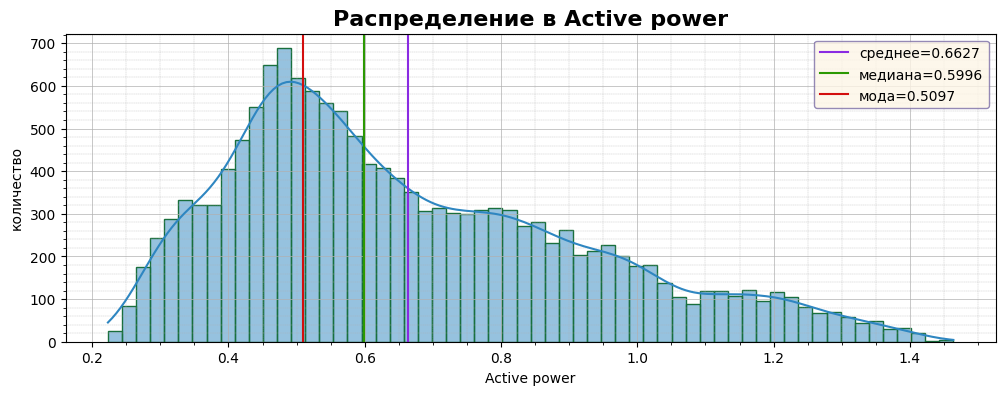

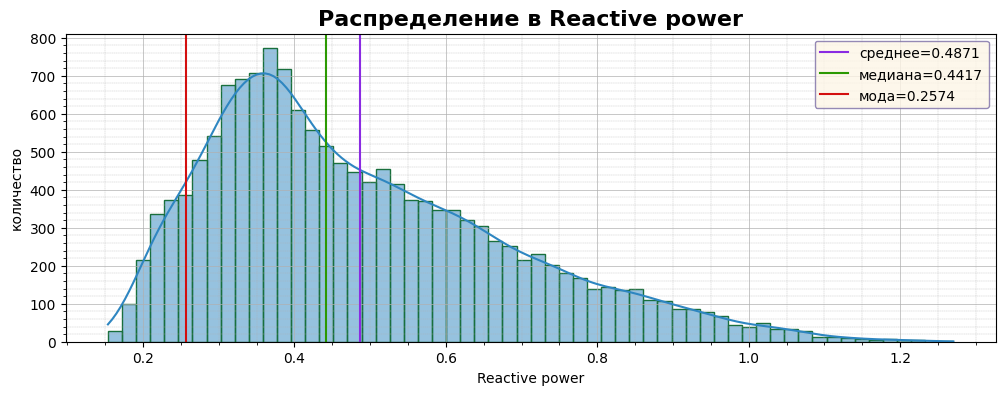

In [7]:
df_arc = df_arc[df_arc['Reactive power'] >= 0]
get_hist(df_arc['Active power'], bins=60)
get_hist(df_arc['Reactive power'], bins=60)

у нас достаточно разных непонятных, на первый взгляд, данных, для того, чтобы на их основе рассчитать важный параметр - мы можем с их помощью оценить затраты энергии на арковую плавку стали, рассчитав энергию, затраченную на проведение плавки, согласно формуле:
$$E = P \cdot \Delta t$$
где: $P$ - активная мощность, а $\Delta t$ - временной интервал

в контексте легирования стали, если мы применим эту формулу к данным арковой плавки (*df_arc*) и предположим, что активная мощность измерена в электрических ваттах (W), то энергия будет выражаться в ватт-часах (Wh):

In [8]:
df_arc['heating time (seconds)'] = (df_arc['Arc heating end'] - 
                           df_arc['Arc heating start']).dt.seconds
df_arc['energy (Wh)'] = df_arc['Active power'] * df_arc['heating time (seconds)']
display(df_arc.head(3), df_arc.tail(3))

,ladle,Arc heating start,Arc heating end,Active power,Reactive power,heating time (seconds),energy (Wh)
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,99.813836


,ladle,Arc heating start,Arc heating end,Active power,Reactive power,heating time (seconds),energy (Wh)
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,30.225219
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,81,31.513617


сгруппируем по среднему данные затрат на энергию и отрисуем распределение:

,count,mean,std,min,25%,50%,75%,max
energy (Wh),3214.0,114.260626,39.151782,20.747014,86.817578,108.656218,137.256432,402.687326


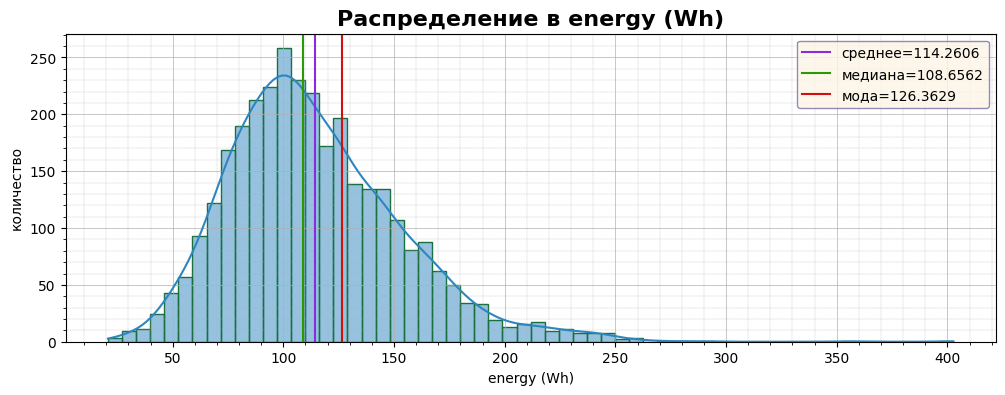

In [9]:
grouped_energy_arc = df_arc.groupby('ladle').agg({'energy (Wh)': np.mean})
display(grouped_energy_arc.describe().T)
get_hist(grouped_energy_arc['energy (Wh)'], bins=60)

видим, что в среднем затрачивается примерно 114.04 ватт-часов энергии на арковую плавку стали, при этом медиана довольно близка к среднему, среднеквадратичное отклонение = 39, но есть довольно длинный хвост справа, намекающий на аномальные затраты энергии.

разобьём распределение на 10%-е процентили и визуализируем его. Если мы имеем дело с выбросом, он точно окажется после 90%-го процентиля, т.е. в хвосте графика:

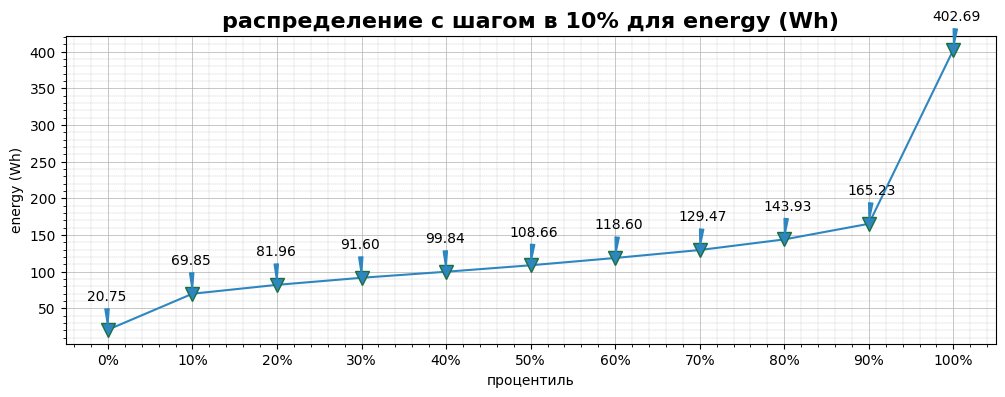

In [10]:
plot_distribution(grouped_energy_arc['energy (Wh)'], up=40)

так и есть, все основные значения находятся за 90%-м перцентилем. Даже если с т.зр. технологического процесса сверхбольшие затраты энергии на плавку стали допустимы, табличную ML-модель они могут сбить с толку, так что для корректности предсказания в дальнейшем от них разумно отказаться, что мы и сделаем со всей мощностью, выходящей за порог в 300 ватт-часов:

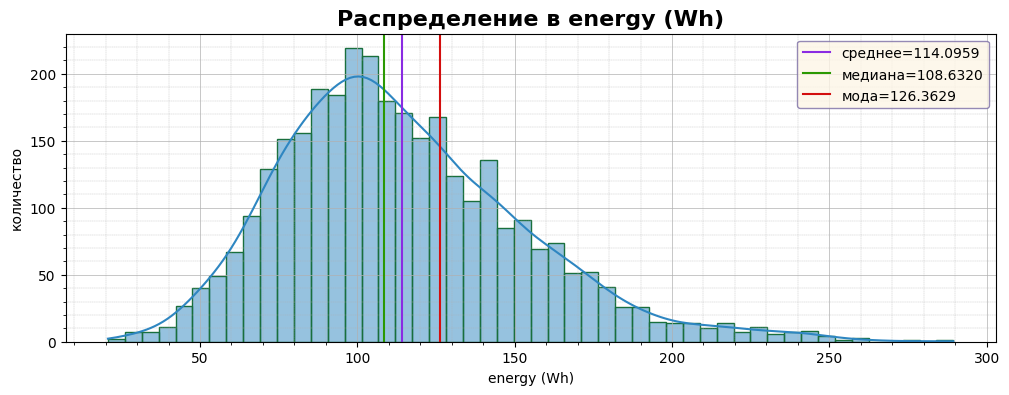

In [11]:
grouped_energy_arc = grouped_energy_arc[grouped_energy_arc['energy (Wh)'] < 300]
get_hist(grouped_energy_arc['energy (Wh)'], bins=50)

#### предварительный вывод:

- изучили датасет - пропуски, распределение, меры центральной тенденции
- исправили формат дат
- удалили явный выброс в *Reactive power*
- рассчитали энергию в ватт-часах (Wh), которая тратится на плавку, удалили в ней затраты свыше 300 Wh, посчитав их за выбросы 

_____

## данные о сыпучих материалах (объём):

In [12]:
get_info(df_bulk)

таблица df_bulk
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ladle            3129 non-null   int64  
 1   Calcium oxide    252 non-null    float64
 2   Magnesium oxide  22 non-null     float64
 3   Aluminum oxide   1298 non-null   float64
 4   Silicon oxide    1014 non-null   float64
 5   Manganese oxide  77 non-null     float64
 6   Iron oxide       576 non-null    float64
 7   Zirconium oxide  25 non-null     float64
 8   Titanium oxide   1 non-null      float64
 9   Boron oxide      19 non-null     float64
 10  Nickel oxide     176 non-null    float64
 11  Copper oxide     177 non-null    float64
 12  Cobalt oxide     2450 non-null   float64
 13  Zinc oxide       18 non-null     float64
 14  Lead oxide       2806 non-null   float64
 15  Sulfur oxide     2248 non-null   float64
dtypes: float64(15), int64(1)


,count,mean,std,min,25%,50%,75%,max
ladle,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Calcium oxide,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Magnesium oxide,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Aluminum oxide,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Silicon oxide,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Manganese oxide,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Iron oxide,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Zirconium oxide,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Titanium oxide,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Boron oxide,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


первые/последние строки:


,ladle,Calcium oxide,Magnesium oxide,Aluminum oxide,Silicon oxide,Manganese oxide,Iron oxide,Zirconium oxide,Titanium oxide,Boron oxide,Nickel oxide,Copper oxide,Cobalt oxide,Zinc oxide,Lead oxide,Sulfur oxide
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,ladle,Calcium oxide,Magnesium oxide,Aluminum oxide,Silicon oxide,Manganese oxide,Iron oxide,Zirconium oxide,Titanium oxide,Boron oxide,Nickel oxide,Copper oxide,Cobalt oxide,Zinc oxide,Lead oxide,Sulfur oxide
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


пропуски в значениях:

ladle                 0
Calcium oxide      2877
Magnesium oxide    3107
Aluminum oxide     1831
Silicon oxide      2115
Manganese oxide    3052
Iron oxide         2553
Zirconium oxide    3104
Titanium oxide     3128
Boron oxide        3110
Nickel oxide       2953
Copper oxide       2952
Cobalt oxide        679
Zinc oxide         3111
Lead oxide          323
Sulfur oxide        881
dtype: int64

явных дубликатов: 0


в значениях нет явных дубликатов, но много пропусков, посмотри на количество значений в каждом признаке:

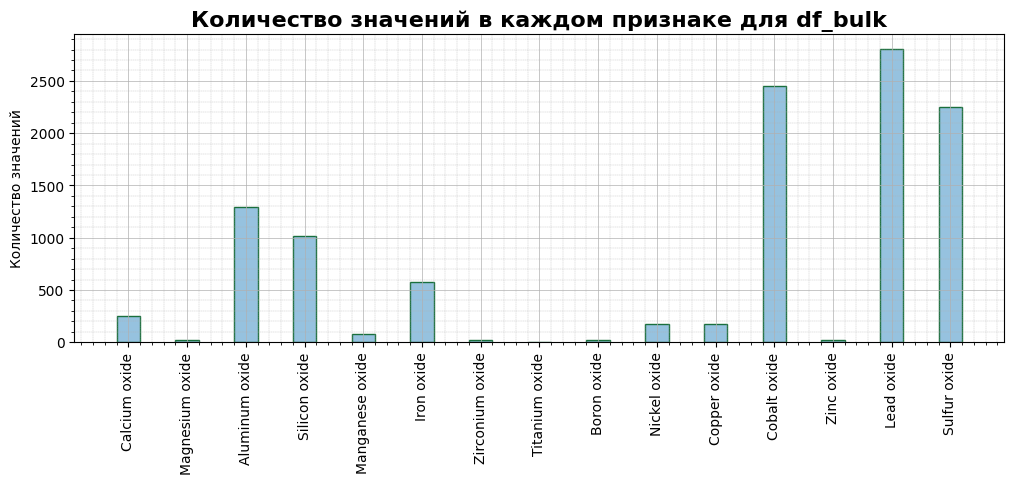

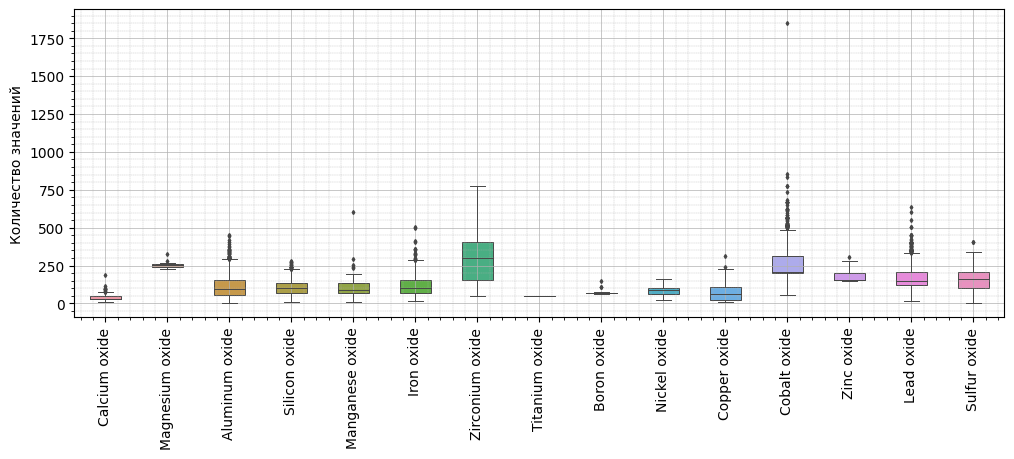

In [13]:
plot_feature_counts(df_bulk, rotation=90)
plot_feature_counts(df_bulk, plot_type='box', rotation=90, not_title=True)

причина пропусков в специфике заполнения таблицы данными - если в определённый момент времени тот или иной материал не подавался в сплав, то значение оставалось незаполненным. И у нас есть признаки, в которых очень много пропусков $\Rightarrow$ признаки с пропусками пока удалять не будем, до каких-либо удалений мы проверим значение всех признаков при помощи библиотеки *SHAP*, использующей в своём алгоритме основу теории игр, а так же статистического *OLS*-теста для независимых выборок с порогом $\alpha$=5%. Пока же без удаления отметим признаки, в которых пропусков > 90% в отдельный список и заполним пропуски как 0

дополнительно видим в оксиде кобальта выброс, если таких значений мало, удалим их:

In [14]:
if df_bulk[df_bulk['Cobalt oxide'] > 1000].shape[0] < 10:
    df_bulk = df_bulk[df_bulk['Cobalt oxide'] < 1000]
remove_columns_bulk_list = [i for i in df_bulk.columns if df_bulk[i].isna().mean() > .9]
df_bulk = df_bulk.fillna(0)

#### предварительный вывод:

- изучили датасет - пропуски, распределение, меры центральной тенденции
- визуализировали количество значений в каждом признаке, определили природу пропусков
- отметили как потенциальные к удалению те признаки, в которых количество пропусков превышает 90%
- сами пропуски заполнили нулём

_____

## данные о сыпучих материалах (время):

таблица df_bulk_time
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ladle            3129 non-null   int64 
 1   Calcium oxide    252 non-null    object
 2   Magnesium oxide  22 non-null     object
 3   Aluminum oxide   1298 non-null   object
 4   Silicon oxide    1014 non-null   object
 5   Manganese oxide  77 non-null     object
 6   Iron oxide       576 non-null    object
 7   Zirconium oxide  25 non-null     object
 8   Titanium oxide   1 non-null      object
 9   Boron oxide      19 non-null     object
 10  Nickel oxide     176 non-null    object
 11  Copper oxide     177 non-null    object
 12  Cobalt oxide     2450 non-null   object
 13  Zinc oxide       18 non-null     object
 14  Lead oxide       2806 non-null   object
 15  Sulfur oxide     2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 

,count,mean,std,min,25%,50%,75%,max
ladle,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


первые/последние строки:


,ladle,Calcium oxide,Magnesium oxide,Aluminum oxide,Silicon oxide,Manganese oxide,Iron oxide,Zirconium oxide,Titanium oxide,Boron oxide,Nickel oxide,Copper oxide,Cobalt oxide,Zinc oxide,Lead oxide,Sulfur oxide
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


,ladle,Calcium oxide,Magnesium oxide,Aluminum oxide,Silicon oxide,Manganese oxide,Iron oxide,Zirconium oxide,Titanium oxide,Boron oxide,Nickel oxide,Copper oxide,Cobalt oxide,Zinc oxide,Lead oxide,Sulfur oxide
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


пропуски в значениях:

ladle                 0
Calcium oxide      2877
Magnesium oxide    3107
Aluminum oxide     1831
Silicon oxide      2115
Manganese oxide    3052
Iron oxide         2553
Zirconium oxide    3104
Titanium oxide     3128
Boron oxide        3110
Nickel oxide       2953
Copper oxide       2952
Cobalt oxide        679
Zinc oxide         3111
Lead oxide          323
Sulfur oxide        881
dtype: int64

явных дубликатов: 0


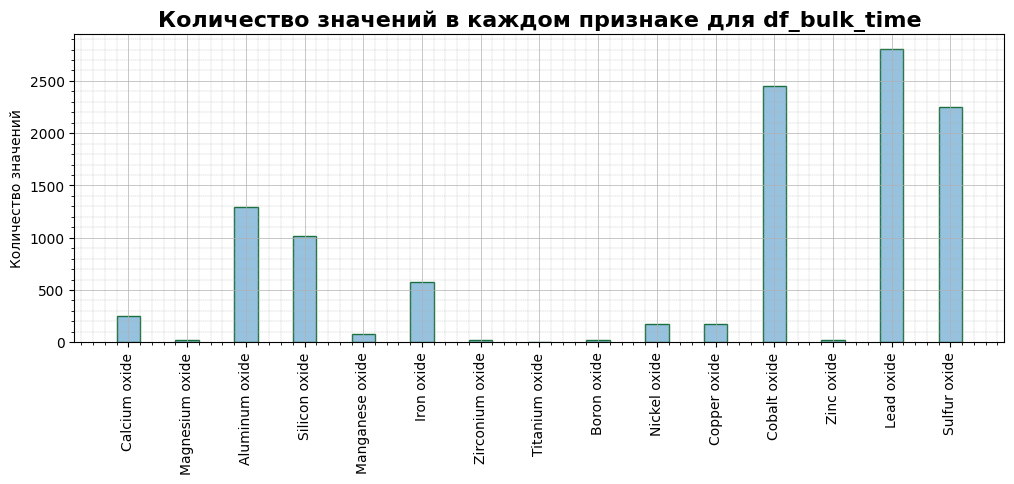

In [15]:
get_info(df_bulk_time)
plot_feature_counts(df_bulk_time, rotation=90)

#### предварительный вывод:

таблица содержит время добавления того или иного сыпучего материала в сплав, т.е. по всем параметрам является чисто информационной и для Machine Learning необязательной.

_____

## данные о проволочных материалах (объём):

таблица df_wire
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ladle            3081 non-null   int64  
 1   Ferrosilicon     3055 non-null   float64
 2   Ferromanganese   1079 non-null   float64
 3   Ferrochrome      63 non-null     float64
 4   Ferrotitanium    14 non-null     float64
 5   Ferronickel      1 non-null      float64
 6   Ferromolybdenum  73 non-null     float64
 7   Ferroboron       11 non-null     float64
 8   Ferroaluminum    19 non-null     float64
 9   Ferrogold        29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

размер: (3081, 10)

статистика:


,count,mean,std,min,25%,50%,75%,max
ladle,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Ferrosilicon,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Ferromanganese,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Ferrochrome,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Ferrotitanium,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Ferronickel,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Ferromolybdenum,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Ferroboron,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Ferroaluminum,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Ferrogold,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


первые/последние строки:


,ladle,Ferrosilicon,Ferromanganese,Ferrochrome,Ferrotitanium,Ferronickel,Ferromolybdenum,Ferroboron,Ferroaluminum,Ferrogold
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ladle,Ferrosilicon,Ferromanganese,Ferrochrome,Ferrotitanium,Ferronickel,Ferromolybdenum,Ferroboron,Ferroaluminum,Ferrogold
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


пропуски в значениях:

ladle                 0
Ferrosilicon         26
Ferromanganese     2002
Ferrochrome        3018
Ferrotitanium      3067
Ferronickel        3080
Ferromolybdenum    3008
Ferroboron         3070
Ferroaluminum      3062
Ferrogold          3052
dtype: int64

явных дубликатов: 0


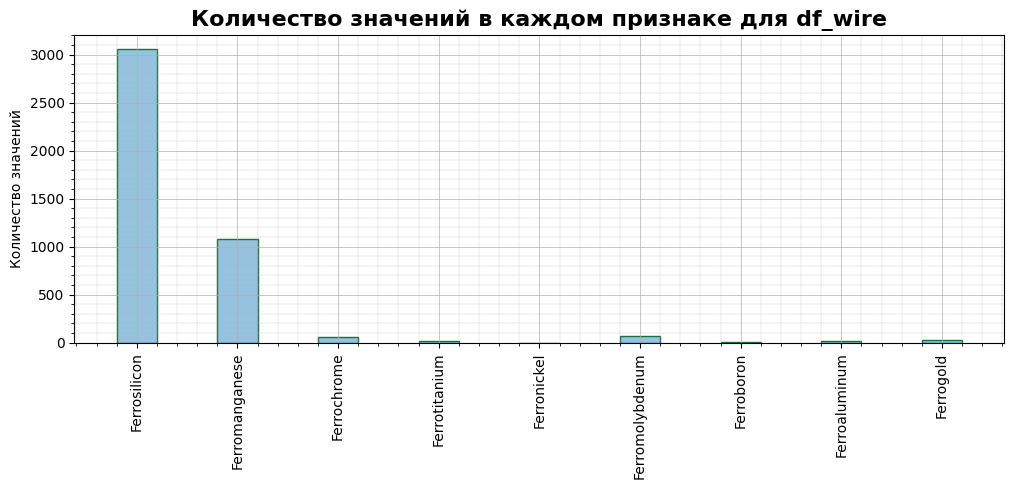

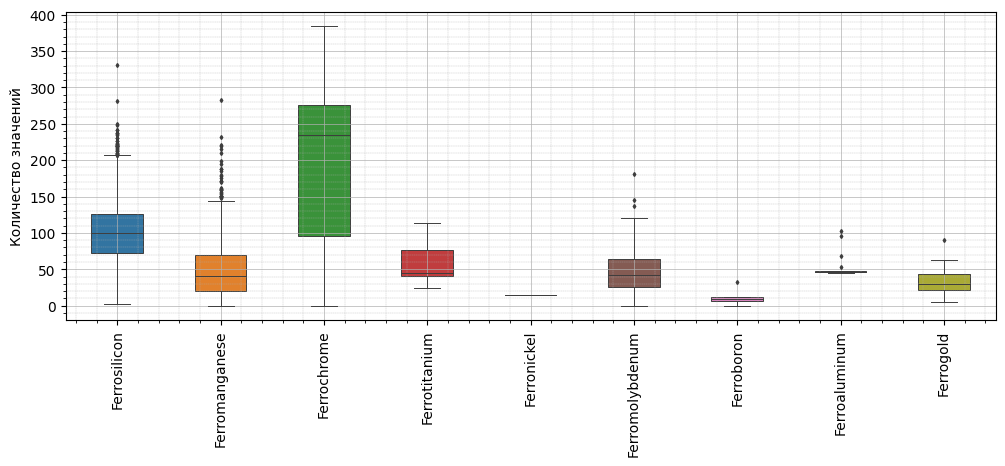

In [16]:
get_info(df_wire)
plot_feature_counts(df_wire, rotation=90)
plot_feature_counts(df_wire, plot_type='box', rotation=90, not_title=True)

причина пропусков в проволочных материалах аналогична сыпучим - их просто не добавляли, поэтому заполним пропуски нулями. Но в целом видим, что большое количество материалов в принципе добавлялось крайне редко, ферроникель так и вовсе однократно. Возможно, это связано со спецификой технологического  процесса, подробную информацию об этом стоит уточнить у заказчика. А пока посмотрим, какой процент пропусков среди проволочных материалов вообще есть:

In [17]:
for column in df_wire.drop(columns='ladle').columns:
    print(f'{Fore.BLUE}{Style.BRIGHT}{column}{Style.RESET_ALL} '\
          f'- пропусков: {df_wire[column].isna().mean():.2%}')

Ferrosilicon - пропусков: 0.84%
Ferromanganese - пропусков: 64.98%
Ferrochrome - пропусков: 97.96%
Ferrotitanium - пропусков: 99.55%
Ferronickel - пропусков: 99.97%
Ferromolybdenum - пропусков: 97.63%
Ferroboron - пропусков: 99.64%
Ferroaluminum - пропусков: 99.38%
Ferrogold - пропусков: 99.06%


предварительно отметим себе как потенциальные к удалению те материалы, пропусков в значении которых > 98%, а пропуски заполним нулями:

In [18]:
remove_columns_wire_list = [i for i in df_wire.columns if df_wire[i].isna().mean() > .98]
df_wire.fillna(0, inplace=True)

#### предварительный вывод:

- изучили датасет - пропуски, распределение, меры центральной тенденции
- визуализировали количество значений в каждом признаке, определили природу пропусков
- отметили как потенциальные к удалению те признаки, в которых количество пропусков превышает 98%
- пропуски заполнили нулём

таблицу *wire_time* рассматривать не будем, так как она, аналогично таблице df_bulk_time содержит время добавления материалов в сплав, т.е. по всем параметрам является чисто информационной и для Machine Learning необязательной.

_____

## данные о продувке сплава аргоном:

таблица df_gas
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ladle   3239 non-null   int64  
 1   Ar      3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

размер: (3239, 2)

статистика:


,count,mean,std,min,25%,50%,75%,max
ladle,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Ar,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


первые/последние строки:


,ladle,Ar
0,1,29.749986
1,2,12.555561
2,3,28.554793


,ladle,Ar
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


пропуски в значениях:

ladle    0
Ar       0
dtype: int64

явных дубликатов: 0


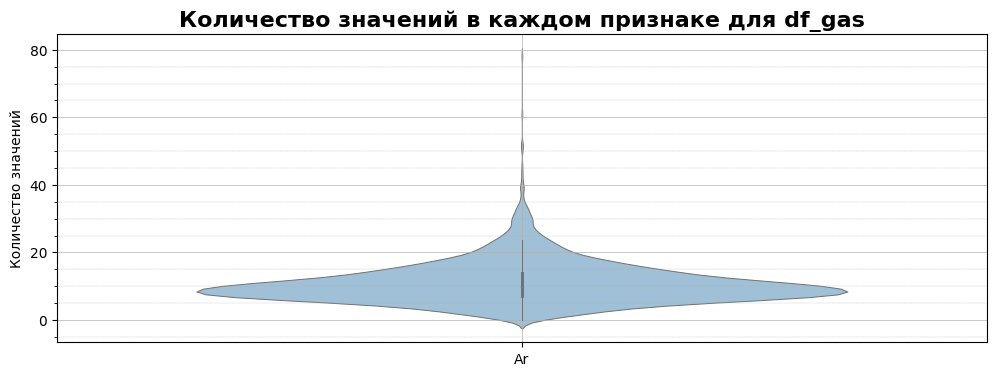

In [19]:
get_info(df_gas)
plot_feature_counts(df_gas, plot_type='violin')

видим довольно большой выброс справа, распределение Пуассона. Не факт, что это крайнее значение - выброс. Посмотрим на распределение с шагом в 10% для понимания того, какие наблюдения находятся в крайних процентилях:

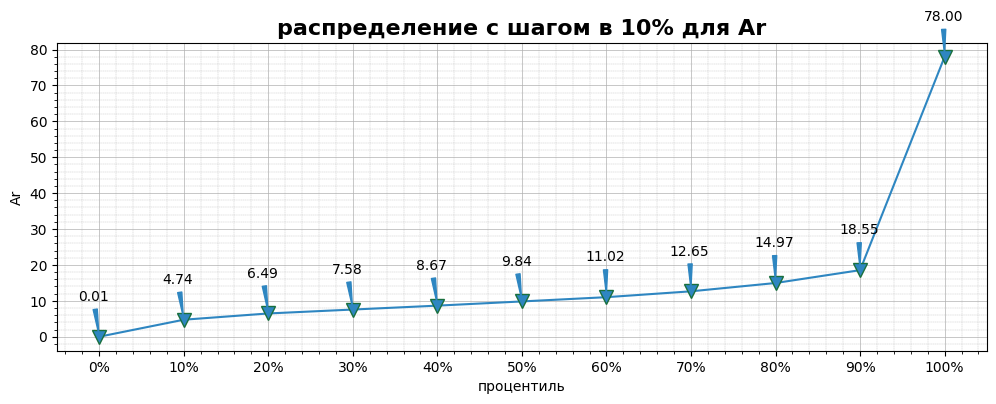

In [20]:
plot_distribution(df_gas['Ar'])

видим, что 90%-й процентиль включает в себя значения до 18.55, дальше, очевидно, выброс $\Rightarrow$ удалим всё, что > 40, если таких значений > 15 и отрисуем ещё раз виолин:

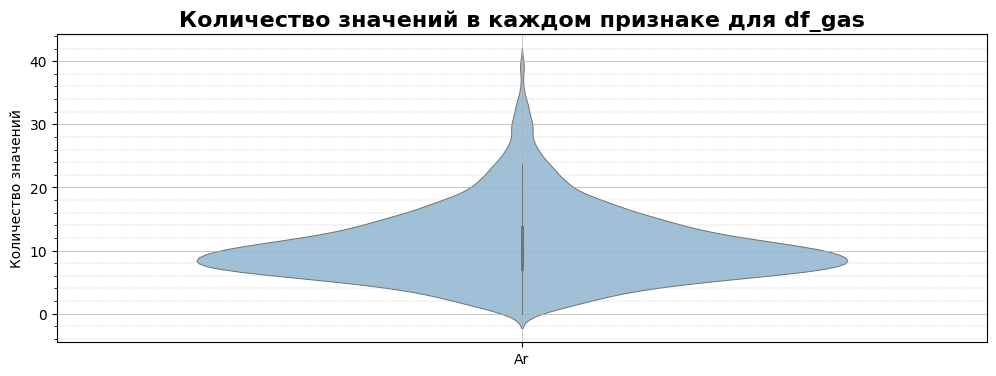

In [21]:
if df_gas[df_gas['Ar'] > 40].shape[0] < 15:
    df_gas = df_gas[df_gas['Ar'] < 40]
plot_feature_counts(df_gas, 'df_gas', plot_type='violin')

#### предварительный вывод:

- изучили датасет - пропусков в нём нет, явных дубликатов нет, признак всего один
- для визуализации распределения отрисовали виолин, на нём определили довольно большой выброс значений, находящихся выше 90% остальных данных, самые крайние значения, их удалили.

_____

## данные об измерениях температуры:

таблица df_temp
общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ladle             18092 non-null  int64  
 1   Measurement time  18092 non-null  object 
 2   Temperature       14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

размер: (18092, 3)

статистика:


,count,mean,std,min,25%,50%,75%,max
ladle,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Temperature,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


первые/последние строки:


,ladle,Measurement time,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


,ladle,Measurement time,Temperature
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


пропуски в значениях:

ladle                  0
Measurement time       0
Temperature         3427
dtype: int64

явных дубликатов: 0


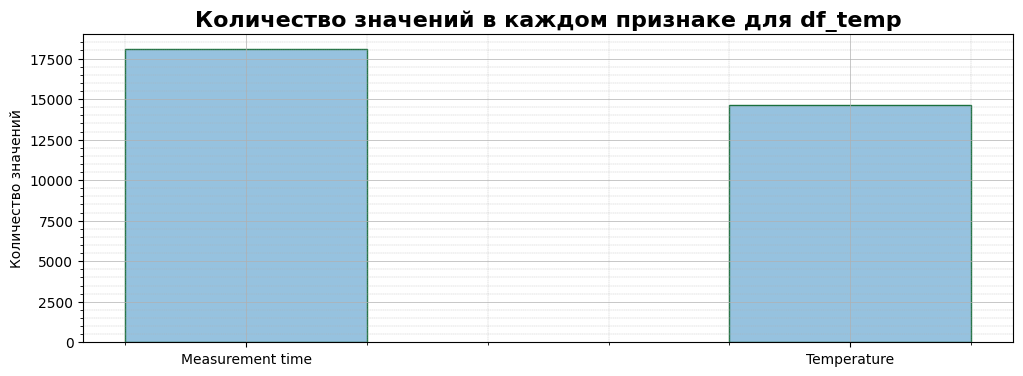

In [22]:
get_info(df_temp)
plot_feature_counts(df_temp)

- значений температуры меньше, чем значений времени замера. Так как мы имеем дело с технологическим процессом, то причин тому может быть множестно, в том числе отказ техники в тот или иной момент процесса 
- ключ на разные наблюдения может совпадать, что верно, так как на один ковш могло приходиться несколько итераций легирования

$\Rightarrow$ переведём *Measurement time* в формат *datetime* и проверим, с какими датами мы имеем дело:

In [23]:
df_temp['Measurement time'] = pd.to_datetime(df_temp['Measurement time'], format='%Y-%m-%d %H:%M:%S')
time_check(df_temp['Measurement time'])

столбец Measurement time
даты распределены неравномерно
начало: 2019-05-03 11:02:04
конец: 2019-09-06 17:30:05


даты идут неравномерно, а вот диапазон времени всё тот же - с 3 мая по 6 сентября 2019-го $\Rightarrow$ отсортируем датасет по дате и посмотрим на распределение температуры:

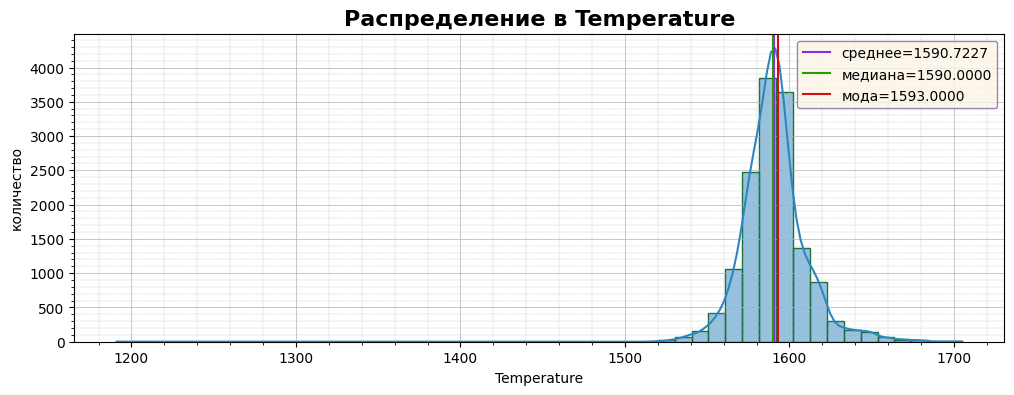

In [24]:
df_temp = df_temp.sort_values('Measurement time')
get_hist(df_temp['Temperature'], bins=50)

видим большой хвост выбросов и низкие температуры, при том что все меры так-то находятся рядом друг с другом и стандартное отклонение 20°. Из [Википедии](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C#:~:text=%D0%A2%D0%B5%D0%BC%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0%20%D0%BF%D0%BB%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%3A%201450%E2%80%941520%20%C2%B0,%D0%92%D1%82%C2%B7%D1%87%2F%D0%BA%D0%B3)) известно, что температура плавления стали: 1450—1520 °C., значит всё, что ниже 1450° мы можем отбросить:

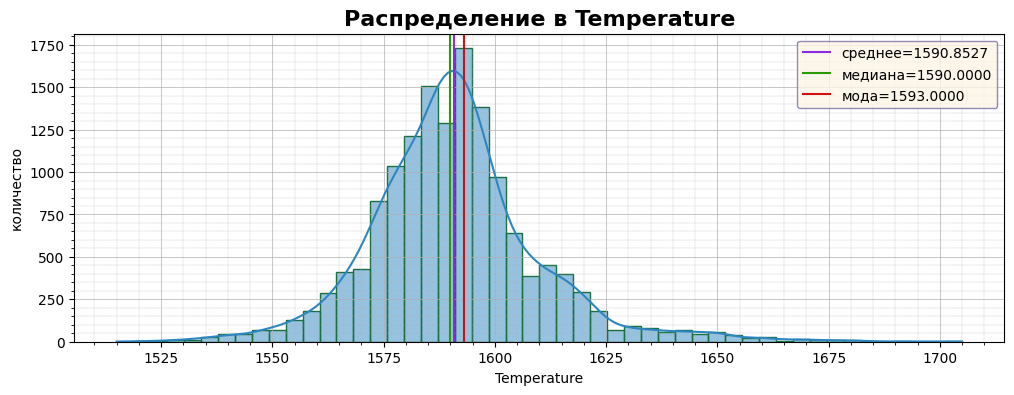

In [25]:
df_temp = df_temp[df_temp['Temperature'] > 1450]
get_hist(df_temp['Temperature'], bins=50)

удаляем все промежуточные технические замеры температуры, оставляем первую и последнюю и найдём время между ними в секундах:

In [26]:
def df_temp_transform(df):
    result = df.groupby('ladle').agg({'Measurement time':['first', 'last'], 'Temperature':['first', 'last']}).reset_index()
    result.columns = result.columns.droplevel()  # снесём двухэтажный индекс
    result.columns = ['ladle', 'first time', 'last time', 'first temperature', 'last temperature']  # переименовываем столбцы
    result['time difference (seconds)'] = (result['last time'] - result['first time']).dt.seconds
    result = result[['ladle', 'time difference (seconds)', 'first temperature', 'last temperature']]  # выбираем столбцы
    return result

df_temp = df_temp_transform(df_temp)
display(df_temp.head(3), df_temp.tail(3))

,ladle,time difference (seconds),first temperature,last temperature
0,1,1714,1571.0,1613.0
1,2,1265,1581.0,1602.0
2,3,1753,1596.0,1599.0


,ladle,time difference (seconds),first temperature,last temperature
3212,3239,0,1598.0,1598.0
3213,3240,0,1617.0,1617.0
3214,3241,0,1586.0,1586.0


#### предварительный вывод:

- изучили датасет - пропуски, распределение, меры центральной тенденции
- исправили формат дат
- отсортировали данные по дате
- удалили аномально низкие температуры стали, при которых она просто не плавится
- удалили все промежуточные температуры, оставив первую и последнюю и замерив в секундах время между ними

_____

## объединяем датасеты в один:

таблицы обработаны, объединим их в единый датафрейм, проверим его на наличие пропусков, а для удобства и соблюдения *PEP-8* приведём названия столбцов к *snake_case*:

In [27]:
df = df_temp.merge(grouped_energy_arc, on='ladle') \
    .merge(df_bulk, on='ladle') \
    .merge(df_wire, on='ladle') \
    .merge(df_gas, on='ladle')

df = df.rename(columns=dict(zip(df.columns, to_snake_case(df.columns))))
print(f'размеры: {df.shape}\nпропусков: {df.isna().sum().sum()}')
display(df.head(3), df.tail(3))

размеры: (2349, 30)
пропусков: 0


,ladle,time_difference_(seconds),first_temperature,last_temperature,energy_(wh),calcium_oxide,magnesium_oxide,aluminum_oxide,silicon_oxide,manganese_oxide,iron_oxide,zirconium_oxide,titanium_oxide,boron_oxide,nickel_oxide,copper_oxide,cobalt_oxide,zinc_oxide,lead_oxide,sulfur_oxide,ferrosilicon,ferromanganese,ferrochrome,ferrotitanium,ferronickel,ferromolybdenum,ferroboron,ferroaluminum,ferrogold,ar
0,1,1714,1571.0,1613.0,125.723386,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1265,1581.0,1602.0,98.820450,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1753,1596.0,1599.0,116.354925,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793


,ladle,time_difference_(seconds),first_temperature,last_temperature,energy_(wh),calcium_oxide,magnesium_oxide,aluminum_oxide,silicon_oxide,manganese_oxide,iron_oxide,zirconium_oxide,titanium_oxide,boron_oxide,nickel_oxide,copper_oxide,cobalt_oxide,zinc_oxide,lead_oxide,sulfur_oxide,ferrosilicon,ferromanganese,ferrochrome,ferrotitanium,ferronickel,ferromolybdenum,ferroboron,ferroaluminum,ferrogold,ar
2346,3237,0,1569.0,1569.0,98.630438,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.543905
2347,3238,0,1584.0,1584.0,76.463620,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.745669
2348,3239,0,1598.0,1598.0,93.959359,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.023518


_____

### feature engineering

до того, как начать удалять тот или иной признак, попробуем сгенерировать несколько новых признаков на основе имеющихся:

In [28]:
# сыпучие добавки (список названий)
bulk_additives = to_snake_case(df_bulk.drop(columns='ladle').columns)
# проволочные добавки (список названий)
wire_additives = to_snake_case(df_wire.drop(columns='ladle').columns)

# суммарное количество сыпучих добавок
df['total_amount_of_bulk_additives'] = df[bulk_additives].sum(axis=1)
# среднее количество сыпучих добавок
df['average_amount_of_bulk_additives'] = df[bulk_additives].mean(axis=1)
# суммарное количество проволочных добавок
df['total_amount_of_wire_additives'] = df[wire_additives].sum(axis=1)
# среднее количество проволочных добавок
df['average_amount_of_wire_additives'] = df[wire_additives].mean(axis=1)
# общее суммарное количество всех добавок
df['total_additives'] = df[bulk_additives+wire_additives].sum(axis=1)
# общее среднее количество всех добавок
df['average_additives'] = df[bulk_additives+wire_additives].mean(axis=1)

# отношение суммы проволочных материалов к сумме сыпучих материалов
df['wire_to_bulk_ratio'] = df['total_amount_of_wire_additives'] / (df['total_amount_of_bulk_additives'] + 1e-5) 

# соотношение всех добавок к проволочным материалам
df['additives_to_wire_materials_ratio'] = df['total_additives'] / (df['average_amount_of_wire_additives'] + 1e-5)

# отношение энергии ко времени
df['energy_per_time'] = df['energy_(wh)'] / (df['time_difference_(seconds)'] + 1e-5)
df.head(3)

,ladle,time_difference_(seconds),first_temperature,last_temperature,energy_(wh),calcium_oxide,magnesium_oxide,aluminum_oxide,silicon_oxide,manganese_oxide,iron_oxide,zirconium_oxide,titanium_oxide,boron_oxide,nickel_oxide,copper_oxide,cobalt_oxide,zinc_oxide,lead_oxide,sulfur_oxide,ferrosilicon,ferromanganese,ferrochrome,ferrotitanium,ferronickel,ferromolybdenum,ferroboron,ferroaluminum,ferrogold,ar,total_amount_of_bulk_additives,average_amount_of_bulk_additives,total_amount_of_wire_additives,average_amount_of_wire_additives,total_additives,average_additives,wire_to_bulk_ratio,additives_to_wire_materials_ratio,energy_per_time
0,1,1714,1571.0,1613.0,125.723386,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,553.0,36.866667,60.059998,6.673333,613.059998,25.544167,0.108608,91.866998,0.073351
1,2,1265,1581.0,1602.0,98.820450,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,582.0,38.800000,96.052315,10.672479,678.052315,28.252180,0.165038,63.532723,0.078119
2,3,1753,1596.0,1599.0,116.354925,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,544.0,36.266667,91.160157,10.128906,635.160157,26.465007,0.167574,62.707612,0.066375


целевой признак у нас - *last_temperature*, её и будем предсказывать. Категориальных признаков у нас нет, а значит мы можем отрисовать корреляцию признаков относительно целевой переменной и друг друга

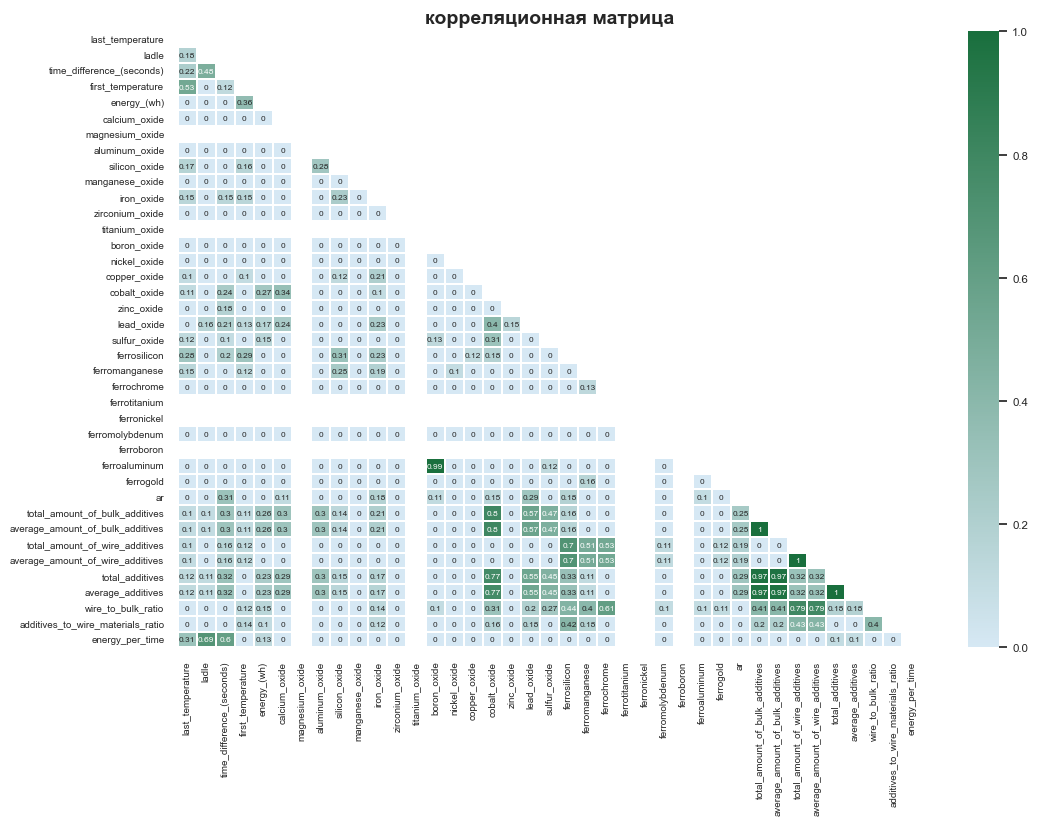

In [29]:
corr_df = df[['last_temperature'] + [col for col in df.columns if col != 'last_temperature']]
get_corr_matrix(np.abs(corr_df.corr()), correlation_threshold=0.1)

- некоторые признаки ничего, кроме 0 в себе не имеют, возможно так произошло после обработки выбросов. В любом случае, сейчас они шумят, поэтому мы их удалим
- удалим мы из пары признаков, которые показывают корреляцию Пирсона выше 0.85 между собой, один признак, так как мультиколлинеарность для модели это плохо, она может влиять на модель, затруднить интерпретацию и уменьшить предсказательную способность
- номер ковша сделаем индексом

In [30]:
list_features_to_removed = ['magnesium_oxide', 'titanium_oxide', 'ferrotitanium', 'ferronickel', 'ferroboron',
                            'ferroaluminum', 'average_amount_of_bulk_additives', 'average_amount_of_wire_additives',
                            'average_additives', 'total_additives']

df = df.drop(columns=list_features_to_removed).set_index('ladle')

остальные признаки так "сгоряча" удалять не будем, изучим их влияние на таргет с точки зрения SHAP-интерпретации. Разобьём выборку на тренировочную и тестовую, проверим размер получившихся выборок:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='last_temperature'), df['last_temperature'],
    test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

print(f'размеры:\n{X_train.shape=}   {y_train.shape=}\n{X_test.shape=}   {y_test.shape=}\n'
      f'доля X_test = {X_test.shape[0]/df.shape[0]:.2%}')

размеры:
X_train.shape=(1761, 27)   y_train.shape=(1761,)
X_test.shape=(588, 27)   y_test.shape=(588,)
доля X_test = 25.03%


### baseline model

посмотрим, что покажет *SHAP*-метод на бустинговой baseline-модели. В качестве алгоритма градиентного бустинга возьмём *LGBMRegressor* от *lightgbm* (он является разработкой Micrisoft и на Windows работает очень шустро):

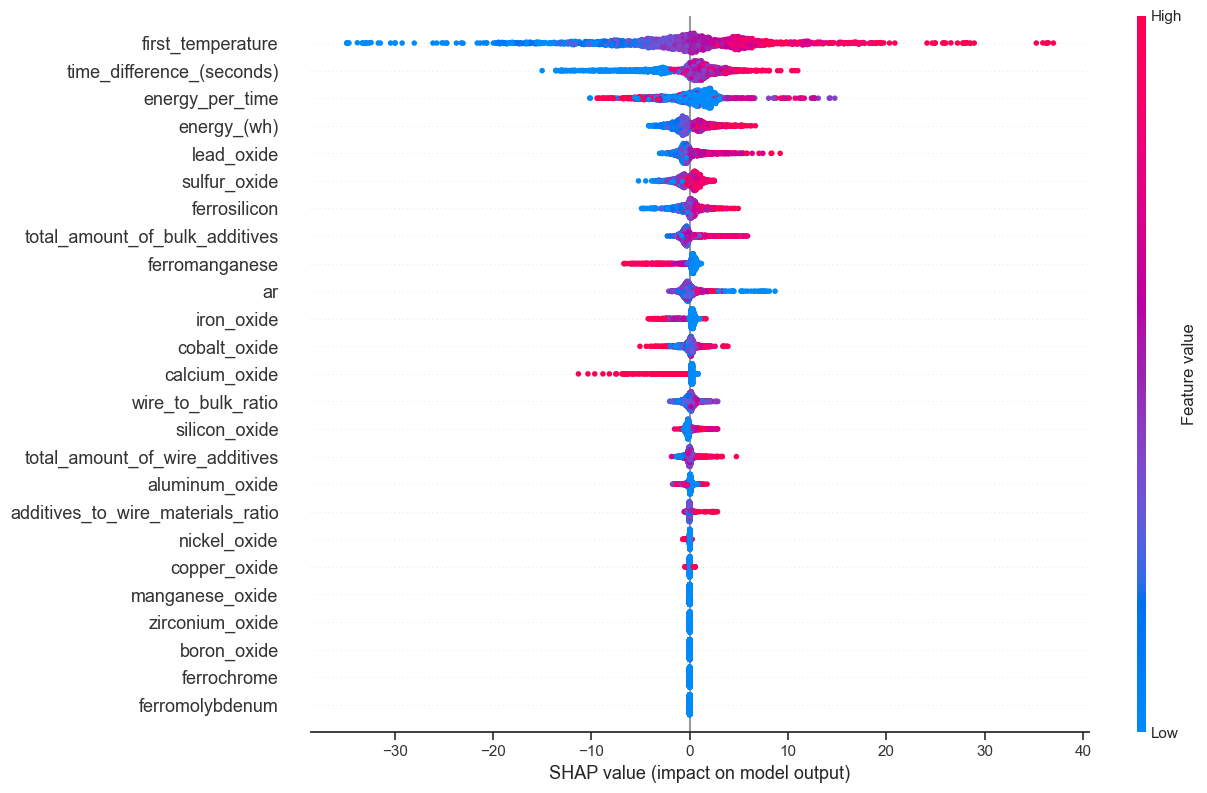

In [32]:
model = LGBMRegressor(verbosity=-1, n_jobs=-1)
return_model_for_shap(X_train, y_train, model)

объясним то, что видим:
- одна точка - одно наблюдение
- цвет точки:
  - красный - здесь большие значения (цифры) у наблюдения 
  - синий - малые значения
- направление отклонения точек относительно базового значения:
  - смещение вправо - положительное влияние признака на увеличение значения целевой переменной
  - смещение влева - отрицательное влияние признака на увеличение значения целевой переменной

видим, что с точки зрения SHAP-модели влияние на целевую переменную имеет всего 21 признак, это:
- ```first_temperature``` - логично, чем выше первая температура, тем выше будет и последняя
- ```energy_per_time``` - отношение энергии ко времени легирования, большое энергопотребление при малом времени легирования предсказуемо вернёт низкий результат
- ```time_difference_(seconds)``` - время легирования, чем дольше "возимся", тем вышем температуру получаем
- ```energy_(wh)``` - аналогично времени - больше тратим, выше температуру получаем
- ```ferrosilicon``` - ферросилиций
- ```lead_oxide``` - оксид свинца
- ```ferromanganese``` - ферромарганец
- ```total_amount_of_bulk_additives``` - суммарное количество сыпучих добавок, больше насыпали, лучше температуру получили
- ```calcium_oxide``` - оксид кальция
- ```sulfur_oxide``` - оксид серы
- ```iron_oxide``` - оксид железа
- ```ar``` - аргон при продуве смеси, большое его количество охлаждает сталь
- ```cobalt_oxide``` - оксид кобальта
- ```wire_to_bulk_ratio``` - отношение проволочных материалов к сыпучим, оно должно быть более-менее равномерным
- ```total_amount_of_wire_additives``` - суммарное количество проволочных материалов, логично - побольше сыпучих если добавили, то и проволочных прибавить не помешает
- ```silicon_oxide``` - оксид кремния
- ```additives_to_wire_materials_ratio``` - соотношение всех добавок к проволочным
- ```aluminum_oxide``` - оксид алюминия
- ```nickel_oxide``` - оксид никеля
- ```copper_oxide``` - оксид меди
- ```ferromolybdenum``` - ферромолибден в самом "хвосте"

и вот кто оказался в "лузерах", не влияющих на температуру согласно SHAPE-интерпретации baseline-модели (они же, кстати, и с т.зр. корреляции Пирсона бессмысленны):
- ```manganese_oxide``` - оксид марганца (корр.Пирсона = 0)
- ```zirconium_oxide``` - оксид циркония (корр.Пирсона = 0)
- ```boron_oxide``` - оксид бора (корр.Пирсона = 0)
- ```zinc_oxide``` - оксид цинка (корр.Пирсона = 0)
- ```ferrochrome``` - феррохром (корр.Пирсона = 0)
- ```ferrogold``` - феррозолото (корр.Пирсона = 0)

для полной уверенности при принятии решения удаления того или иного признака мы проверим их влияние и с помощью метода OLS (Ordinary Least Squares) для построения модели регрессии (метод наименьших квадратов), он стремится минимизировать сумму квадратов остатков (разница между фактическими значениями целевой переменной и предсказанными значениями), чтобы найти наилучшие оценки коэффициентов регрессии. Сформулируем гипотезы:

- $H_0$ - признак не имеет влияния не целевую переменную
- $H_1$ - признак имеет влияния не целевую переменную

уровень значимости укажем 5% и вот что получится:

Dep. Variable:,target,R-squared (uncentered):,1.000
Model:,OLS,Adj. R-squared (uncentered):,1.000
Method:,Least Squares,F-statistic:,6.082e+05
Date:,"Mon, 02 Oct 2023",Prob (F-statistic):,0.00
Time:,22:59:59,Log-Likelihood:,-7455.0
No. Observations:,1761,AIC:,1.496e+04
Df Residuals:,1735,BIC:,1.510e+04
Df Model:,26,,
Covariance Type:,nonrobust,,


,features,coef,std err,t,P>|t|,[0.025,0.975],is important
0,time_difference_(seconds),-0.0030,0.000,-8.215,0.000,-0.004,-0.002,True
24,wire_to_bulk_ratio,41.8593,11.415,3.667,0.000,19.470,64.249,True
3,calcium_oxide,-0.2480,0.055,-4.538,0.000,-0.355,-0.141,True
26,energy_per_time,-1.287e-06,1.03e-07,-12.465,0.000,-1.49e-06,-1.08e-06,True
1,first_temperature,0.9797,0.002,515.143,0.000,0.976,0.983,True
2,energy_(wh),0.2035,0.011,18.004,0.000,0.181,0.226,True
21,ar,0.1401,0.079,1.778,0.076,-0.014,0.295,False
25,additives_to_wire_materials_ratio,0.0075,0.006,1.170,0.242,-0.005,0.020,False
14,lead_oxide,0.0480,0.044,1.093,0.274,-0.038,0.134,False
8,zirconium_oxide,-0.1983,0.213,-0.932,0.351,-0.615,0.219,False


Omnibus:,31.335,Durbin-Watson:,1.943
Prob(Omnibus):,0.000,Jarque-Bera (JB):,49.454
Skew:,-0.158,Prob(JB):,1.82e-11
Kurtosis:,3.758,Cond. No.,1.33e+16


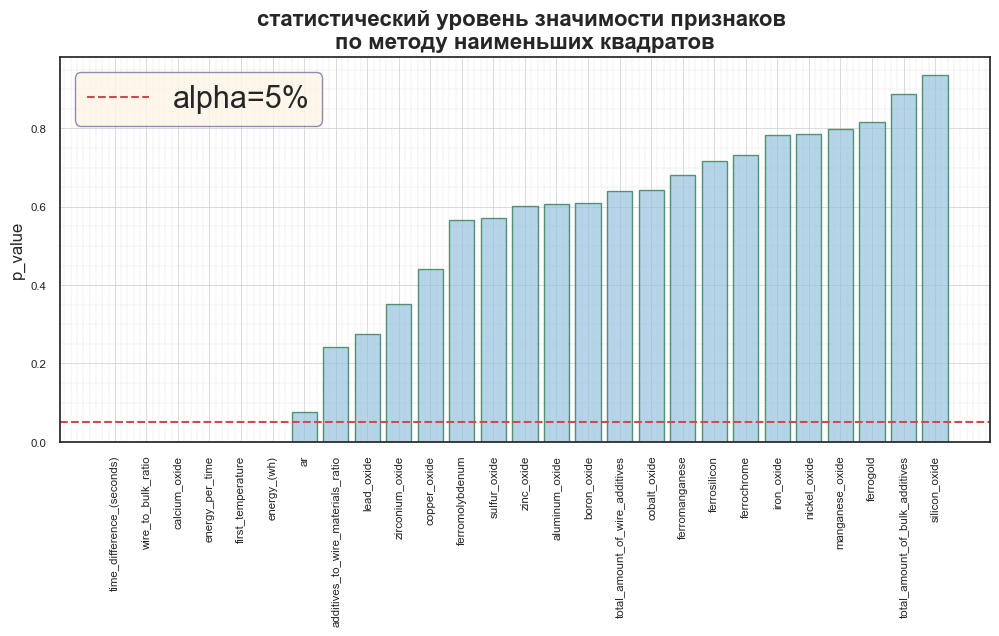

In [33]:
evaluate_feature_significance_ols(X_train, y_train)

по методу наименьших квадратов мы можем отклонить нулевую гипотезу только для шести признаков - это:
- ```time_difference_(seconds)``` - время легирования
- ```wire_to_bulk_ratio``` - отношение проволочных материалов к сыпучим
- ```calcium_oxide``` - оксид кальция
- ```energy_per_time``` - отношение энергии ко времени легирования
- ```first_temperature``` - первый замер температуры
- ```energy_(wh)``` - затраты энергии на арковую плавку в ватт-часах

по остальным признакам мы не можем отклонить нулевую гипотезу, с вероятностью в 95% они являются статистически незначимыми и, скорее всего, не влияют на целевую переменную.

у нас ещё и $R^2=1$, что указывает на то, что модель хорошо объясняет данные. Поверим стат. показателям, которые в совокупности с методом SHAP и корреляцией Пирсона доказали нам то, что 6 признаков-"лузеров" мы можем удалить:

In [34]:
list_features_to_removed = ['manganese_oxide', 'zirconium_oxide', 'boron_oxide',
                              'zinc_oxide', 'ferrochrome', 'ferrogold']
X_train = X_train.drop(columns=list_features_to_removed)
X_test = X_test.drop(columns=list_features_to_removed)

в итоге модель мы будем строить на этих признаках, так как при помощи разных методов они так или иначе показали свою значимость для целевой переменной:

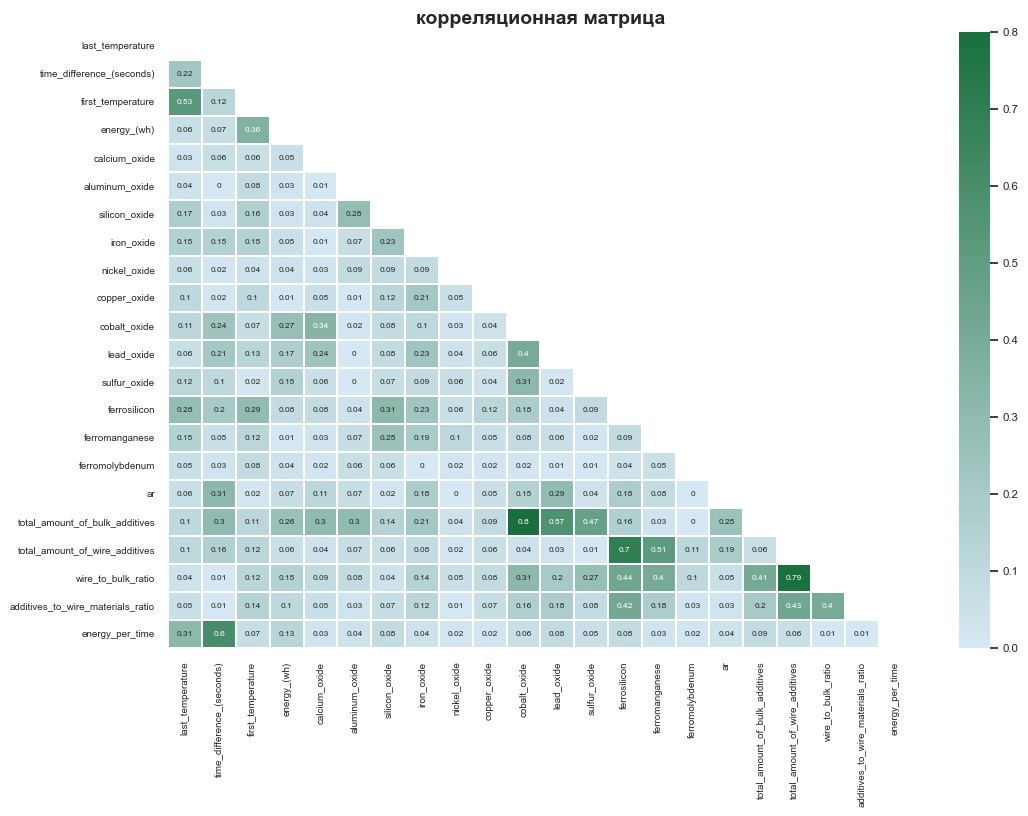

In [35]:
corr_df = df[['last_temperature'] + [col for col in df.columns if col != 'last_temperature']] \
    .drop(columns=list_features_to_removed)
get_corr_matrix(np.abs(corr_df.corr()), correlation_threshold=0.01)

#### предварительный вывод:

- объединили все имеющиеся в нашем распоряжении данные в единый датасет
- определили целевую переменную - это *last_temperature* время последнего замера температуры
- feature engineering - сгенерировали ряд новых признаков
- разделили датасет на две выборки - тренировочную и тестовую, оставили на тест 25% данных
- при помощи нескольких методов, в т.ч. с оценкой baseline-модели изучили влияние признаков на целевую переменную. Эти методы:
  - оценка корреляции Пирсона
  - интерпретация SHAP-модели
  - статистическая оценка модели регрессии методом наименьших квадратов
- определились с признаками, которые будут участвовать в ML-обучении, лишние удалили, нужные оставили

_____

## Поиск оптимального алгоритма и создание ML-модели

переберём несколько алгоритмов с параметрами, подобранными при помощи RandomizedSearchCV, посчитаем на тренировочных данных с применением кросс-валидации метрики MAE и RMSE и соберём результаты и обученные модели в единую структуру-список pipeline_and_predicts_list, после из него потом будет выбирать "победителя", обращаясь к обученной модели по идексу. А для всех манипуляций с обучением и сбором данных у нас есть класс ModelAnalyzer, к его экземпляру и будем обращаться:

In [36]:
# список:
pipeline_and_predicts_list = list()

# для удобства сохраним название столбцов в переменную:
str_train = 'MAE на train при cross validation'
str_test = 'MAE на test'

# вот экземпляр класса ModelAnalyzer:
analyzer = ModelAnalyzer()

# списки колонок
analyzer.other_cols = X_train.columns.tolist()

_____

#### LinearRegression

для линейной регрессии переберём такие параметры:
- ```fit_intercept``` - добавлять ли интерсепт
- ```positive``` - делать ли все коэффициенты положительными

In [37]:
%%time
model = LinearRegression()
params = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params, standardize=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__positive': False, 'regressor__fit_intercept': False}
 ------------------------------


,модель,RMSE,MAE на train при cross validation
0,LinearRegression(fit_intercept=False),10.98,8.6


CPU times: total: 31.2 ms
Wall time: 2.02 s


_____

#### Ridge

параметры для Ridge:
- ```alpha``` - коэффициент регуляризации.
- ```fit_intercept``` - указывает, следует ли включать константу в модель.
- ```solver``` - алгоритм для решения оптимизационной задачи.

In [38]:
%%time
model = Ridge()
params = {
    'regressor__alpha': [0.1, 1, 10],
    'regressor__fit_intercept': [True, False],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params, standardize=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__solver': 'lsqr', 'regressor__fit_intercept': True, 'regressor__alpha': 1}
 ------------------------------


,модель,RMSE,MAE на train при cross validation
1,"Ridge(alpha=1, solver='lsqr')",11.0,8.59


CPU times: total: 109 ms
Wall time: 434 ms


_____

#### Lasso

параметры для Lasso:
- ```alpha``` - коэффициент регуляризации.
- ```fit_intercept``` - указывает, следует ли включать константу в модель.
- ```selection``` - метод выбора признаков (cyclic - циклический, random - случайный).

In [39]:
%%time
model = Lasso()
params = {
    'regressor__alpha': [0.1, 1, 10],
    'regressor__fit_intercept': [True, False],
    'regressor__selection': ['cyclic', 'random']
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params, standardize=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__selection': 'random', 'regressor__fit_intercept': True, 'regressor__alpha': 0.1}
 ------------------------------


,модель,RMSE,MAE на train при cross validation
2,"Lasso(alpha=0.1, selection='random')",11.29,8.76


CPU times: total: 15.6 ms
Wall time: 150 ms


_____

#### RandomForestRegressor

для леса переберём такие параметры:
- ```n_estimators``` - количество деревьев в лесу.
- ```max_features``` - количество признаков для поиска наилучшего разделения при построении каждого дерева.
- ```max_depth``` - максимальная глубина каждого дерева.
- ```min_samples_split``` - минимальное количество образцов, необходимых для разделения внутреннего узла.
- ```min_samples_leaf``` - минимальное количество образцов, необходимых для быть листом.
- ```bootstrap``` - использовать ли бутстрэп для выборки образцов.
- ```oob_score``` - использовать ли out-of-bag ошибку для оценки обобщающей способности модели.

In [40]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)
params = {
    'regressor__n_estimators': sp_randint(200, 1000),
    'regressor__max_features': [1.0, 'sqrt', 'log2'],
    'regressor__max_depth': [-1, 5, 10, 20],
    'regressor__min_samples_split': sp_randint(2, 12),
    'regressor__min_samples_leaf': sp_randint(1, 6),
    'regressor__bootstrap': [True, False],
    'regressor__oob_score': [True, False],
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__max_features': 1.0, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 863, 'regressor__oob_score': False}
 ------------------------------


,модель,RMSE,MAE на train при cross validation
3,"RandomForestRegressor(max_depth=10, min_sample...",4.87,5.65


CPU times: total: 29.2 s
Wall time: 14min 58s


_____

#### LGBMRegressor

для бустинга у нас такие параметры:
- ```n_estimators``` - количество деревьев в ансамбле.
- ```learning_rate``` - шаг градиентного спуска.
- ```max_depth``` - максимальная глубина каждого дерева.
- ```num_leaves``` - максимальное количество листьев в каждом дереве.
- ```min_child_samples``` - минимальное количество образцов в листе.
- ```subsample``` - доля образцов для обучения каждого дерева.
- ```colsample_bytree``` - доля признаков для обучения каждого дерева.
- ```reg_alpha``` - коэффициент L1-регуляризации.
- ```reg_lambda``` - коэффициент L2-регуляризации.

In [41]:
%%time
model = LGBMRegressor(verbosity=-1, n_jobs=-1, random_state=RANDOM_STATE)
params = {
    'regressor__n_estimators': sp_randint(200, 1000),
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [-1, 5, 10, 20],
    'regressor__num_leaves': sp_randint(31, 128),
    'regressor__min_child_samples': sp_randint(20, 101),
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0.0, 0.1, 0.5],
    'regressor__reg_lambda': [0.0, 0.1, 0.5]
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_child_samples': 22, 'regressor__n_estimators': 233, 'regressor__num_leaves': 73, 'regressor__reg_alpha': 0.5, 'regressor__reg_lambda': 0.0, 'regressor__subsample': 0.6}
 ------------------------------


,модель,RMSE,MAE на train при cross validation
4,"LGBMRegressor(learning_rate=0.05, max_depth=5,...",5.38,5.83


CPU times: total: 16.1 s
Wall time: 18min 8s


_____

#### K-Nearest Neighbors Regressor

для соседей параметры:
- ```n_neighbors``` - количество соседей для использования в прогнозе.
- ```weights``` - веса для прогноза на основе расстояния до соседей.
- ```algorithm``` - алгоритм для вычисления ближайших соседей.
- ```leaf_size``` - размер листа для BallTree или KDTree.
- ```p``` - степень метрики Минковского. 1 - Манхэттенское расстояние, 2 - Евклидово расстояние.

In [42]:
%%time
model = KNeighborsRegressor(n_jobs=-1)
params = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'regressor__leaf_size': [10, 20, 30, 40],
    'regressor__p': [1, 2]
}

pipeline, table_row, y_pred_train =\
    analyzer.choosing_best_model(model, X_train, y_train, param_grid=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
display(table_row.pivot_table.drop(columns=str_test).iloc[[-1]].round(2))

------------------------------ 
подобранные параметры:
{'regressor__weights': 'uniform', 'regressor__p': 1, 'regressor__n_neighbors': 9, 'regressor__leaf_size': 10, 'regressor__algorithm': 'auto'}
 ------------------------------


  File "C:\Users\Mysha\anaconda3\envs\ds_practicum_env3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,модель,RMSE,MAE на train при cross validation
5,"KNeighborsRegressor(leaf_size=10, n_jobs=-1, n...",12.14,9.91


CPU times: total: 1.31 s
Wall time: 4.35 s


#### предварительный вывод:
- использовали класс *ModelAnalyzer*, который:
  - по разному, в зависимости от переданных гиперпараметров, трансформирует данные
  - на кросс-валидации подбирает лучшие гиперпараметры и обучает пайплайн
  - заполняет строку в сводной таблице значениями:
    - название модели
    - RMSE
    - MAE на train при cross validation
    - MAE на test
  - и возвращает:
    - обученный пайплайн
    - вектор с предсказаниями
- обучили и получили предсказания ит замеры времени для следующих алгоритмов:
  - линейные:
    - LinearRegression
    - Ridge
    - Lasso
  - деревянные:
    - RandomForestRegressor
    - LGBMRegressor
  - K ближайших соседей KNeighborsRegressorr

Все полученные значения собраны в сводную таблицу и список pipeline_and_predicts_list и готовы к анализупеременных

_____

## Анализ моделей

смотрим на готовый результат:

,модель,RMSE,MAE на train при cross validation
3,"RandomForestRegressor(max_depth=10, min_sample...",4.867690,5.646630
4,"LGBMRegressor(learning_rate=0.05, max_depth=5,...",5.380517,5.833361
1,"Ridge(alpha=1, solver='lsqr')",11.000750,8.587739
0,LinearRegression(fit_intercept=False),10.982323,8.604615
2,"Lasso(alpha=0.1, selection='random')",11.289103,8.759115
5,"KNeighborsRegressor(leaf_size=10, n_jobs=-1, n...",12.135080,9.913290


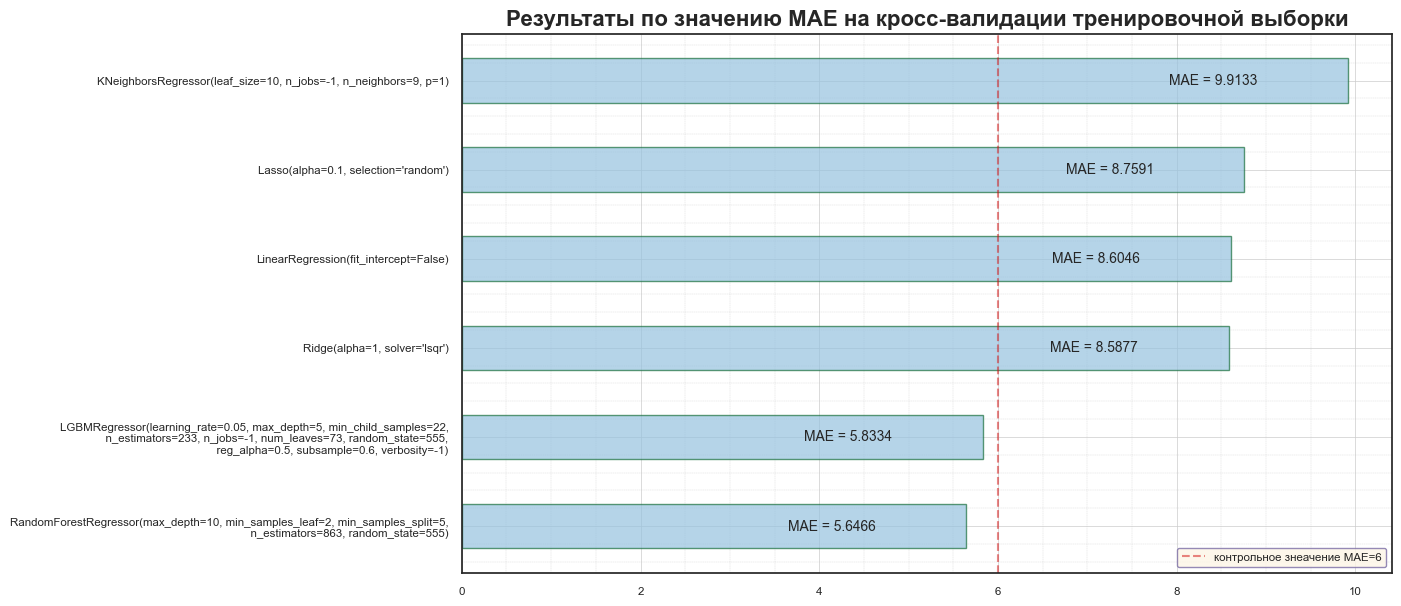

In [43]:
result_table = GetFinalTable.pivot_table.drop(columns=str_test) \
    .sort_values(str_train)
display(result_table)
plot_barh(result_table)

лес и бустинг оказались лучшими и это вполне ожидаемо, так как они лучше гругих справляются с табличными данными. Но прежде чем останавливаться на каком-то одном из разработанных алгоритмов, попробуем их предсказания пообъединять в виде ансамблей

обученные пайплайны и векторы с полученными предсказаниями у нас лежат в списке pipeline_and_predicts_list, мы с помощью itertools.combinations в цикле переберём все пары алгоритмов и посчитаем MAE на их усреднённых предсказаниях, а результат добавим в нашу сводную таблицу и посмотрим на ТОП-5 алгоритмов, отфильтровар таблицу по лучшему значению RMSE:

In [44]:
predictions_list = [predictions for _, _, predictions in pipeline_and_predicts_list]
model_names = [model_name for model_name, _, _ in pipeline_and_predicts_list]

for pair in itertools.combinations(model_names, 2):
    indices = [model_names.index(index_model) for index_model in pair]       # получаем индексы моделей
    predictions_subset = [predictions_list[i] for i in indices]
    
    ensemble_predictions = sum(predictions_subset) / len(predictions_subset) # усредняем предсказания
    mae_ = mean_absolute_error(y_train, ensemble_predictions)
    rmse = mean_squared_error(y_train, ensemble_predictions, squared=False)
    ensemble_name = '-'.join(pair)                                           # строка с названием композиции
    table_row = GetFinalTable(ensemble_name, rmse, mae_)
table_row.pivot_table.drop(columns=str_test).sort_values(str_train).head(5).round(2)

,модель,RMSE,MAE на train при cross validation
18,RandomForestRegressor-LGBMRegressor,5.03,3.57
3,"RandomForestRegressor(max_depth=10, min_sample...",4.87,5.65
8,LinearRegression-RandomForestRegressor,7.34,5.75
12,Ridge-RandomForestRegressor,7.36,5.77
4,"LGBMRegressor(learning_rate=0.05, max_depth=5,...",5.38,5.83


видим, что лучшее значение MAE дайт пара лес+бустинг. Даже если MAE на тестовой выборке будет немного выше, чем при использовании алгоритмов по отдельности, объединение двух алгоритмов из разных "семейств" даст нам большую надёжность разработанной модели и сгладит риски переобучения

посмотрим на пайплайны леса и бустинга, чтоб убедиться в том, что они хранятся под своими индексами:

In [45]:
display(pipeline_and_predicts_list[-3][1], pipeline_and_predicts_list[-2][1])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('num', 'passthrough',
                                                  ['time_difference_(seconds)',
                                                   'first_temperature',
                                                   'energy_(wh)',
                                                   'calcium_oxide',
                                                   'aluminum_oxide',
                                                   'silicon_oxide',
                                                   'iron_oxide', 'nickel_oxide',
                                                   'copper_oxide',
                                                   'cobalt_oxide', 'lead_oxide',
                                                   'sulfur_oxide',
                                                   'fer...',
                                                   'ferromanganese',
                                                   'ferromolybdenum', 'ar',
                                                   'total_amount_of_bulk_additives',
                                                   'total_amount_of_wire_additives',
                                                   'wire_to_bulk_ratio',
                                                   'additives_to_wire_materials_ratio',
                                                   'energy_per_time'])])),
                ('poly', PolynomialFeatures(degree=1)),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=863,
                                       random_state=555))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('num', 'passthrough',
                                                  ['time_difference_(seconds)',
                                                   'first_temperature',
                                                   'energy_(wh)',
                                                   'calcium_oxide',
                                                   'aluminum_oxide',
                                                   'silicon_oxide',
                                                   'iron_oxide', 'nickel_oxide',
                                                   'copper_oxide',
                                                   'cobalt_oxide', 'lead_oxide',
                                                   'sulfur_oxide',
                                                   'fer...
                                                   'total_amount_of_bulk_additives',
                                                   'total_amount_of_wire_additives',
                                                   'wire_to_bulk_ratio',
                                                   'additives_to_wire_materials_ratio',
                                                   'energy_per_time'])])),
                ('poly', PolynomialFeatures(degree=1)),
                ('regressor',
                 LGBMRegressor(learning_rate=0.05, max_depth=5,
                               min_child_samples=22, n_estimators=233,
                               n_jobs=-1, num_leaves=73, random_state=555,
                               reg_alpha=0.5, subsample=0.6, verbosity=-1))])

проверим разработанную модель и посчитаем метрики на отложенной выборке:

In [46]:
y_test_predict_first = pipeline_and_predicts_list[-3][1].predict(X_test)
y_test_predict_second = pipeline_and_predicts_list[-2][1].predict(X_test)
y_test_predict = np.array([y_test_predict_first, y_test_predict_second]).mean(axis=0)

table_row = GetFinalTable(f'{pipeline_and_predicts_list[-3][0]} + {pipeline_and_predicts_list[-2][0]}',
                          mean_squared_error(y_test, y_test_predict, squared=False),
                          0, mean_absolute_error(y_test, y_test_predict))
table_row.pivot_table.drop(columns=[str_train]).iloc[[-1]]

,модель,RMSE,MAE на test
21,RandomForestRegressor + LGBMRegressor,7.273358,5.064361


#### предварительный вывод:
- проанализировали сводную таблицу с полученными предсказаниями от разных алгоритмов
- с помощью itertools.combinations в цикле попарно перебрали все алгоритмы и посчитаем MAE на их усреднённых предсказаниях
- выбрали алгоритм, показавший лучшее значение MAE, им оказался:
  - RandomForestRegressor + LGBMRegressor
- проверили выбранный алгоритм на отложенной выборке, получив значение MAE ниже контрольного порога в 6°C

_____

## Проверка на адекватность - сравнение выбранной модели с константной dummy-моделью

для того, чтобы быть уверенными наверняка в том, что наша модель действительно работает и корректно предстазывает температуру, сравним её с константной dummy-моделью, которая всегда предсказывает среднее значение:

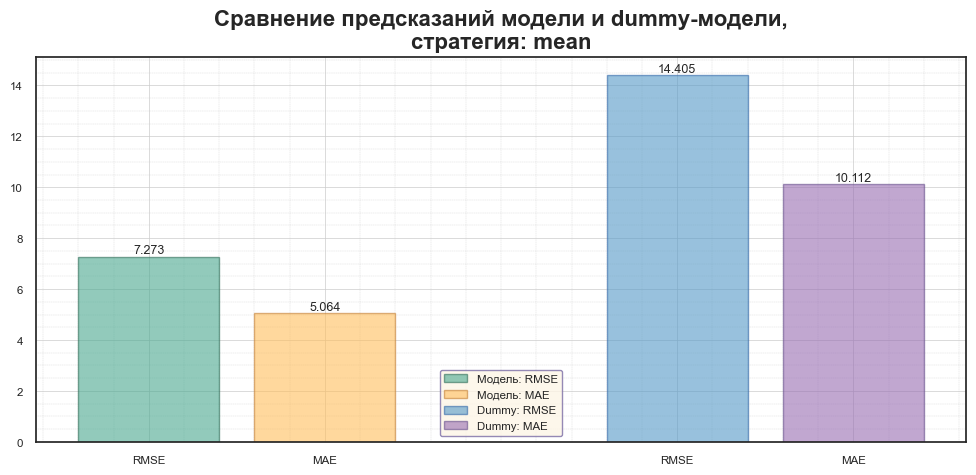

In [47]:
model_rmse = GetFinalTable.pivot_table[GetFinalTable.pivot_table.columns[1]].iloc[-1]
model_mae = GetFinalTable.pivot_table[GetFinalTable.pivot_table.columns[3]].iloc[-1]
pred_tuple = (model_rmse, model_mae)
model_comparison(X_train, y_train, X_test, y_test, pred_tuple)

видим что модель наша молодец и с поставленной задачей справляется, достигая значения MAE иже установленногго порога в 6°C

сохраним её в файл

In [48]:
folder_name = 'pipelines'
try:
    os.mkdir(folder_name)
except FileExistsError:
    pass

joblib.dump(pipeline_and_predicts_list[-3][1], os.path.join(folder_name, f'pipeline_RandomForestRegressor'))
joblib.dump(pipeline_and_predicts_list[-2][1], os.path.join(folder_name, f'pipeline_LGBMRegressor'))

['pipelines\\pipeline_LGBMRegressor']

#### предварительный вывод:
- провери контрольную проверку выбранного алгоритма, сравнив его предсказания с dummy-моделью
- сохранили разработанный нами алгоритм в файл

_____

## Общий вывод

в рамках проекта мы разработали модель машинного обучения, которая поможет металлургическому комбинату оптимизировать производственные расходы за счёт уменьшения энергопотребления и износа оборудования, так как будет проверять температуру стали, подаваемой на доводку. Если температура партии сплава окажется неподходящей, модель сообщит об этом и такой сплав "отбракуется" и отправится на дополнительный этап легирования. 

для разработки модели мы проделали следующие шаги:
- исследовали данные
- подготовили их к обучению, а именно:
  - изучили распределение данных
  - выявили и удалили аномалии
  - разобрались в природе пропусков, заполнили их
  - объединили таблицы в единый датасет
  - сгенерировали ряд новаых признаков
  - оценили влияние признаков на целевую переменную несколькими способами:
    - корреляцией Пирсона
    - SHAP-моделью
    - методом наименьших квардатор при уровне значимости $\alpha=5\%$
- при помощи *RandomizedSearchCV* и кросс-валидации рассмотрели несколько ML-алгоритмов как по отдельности, так и их попарные ансамбли:
  - 3 линейных: *LinearRegression*, *Ridge*, *Lasso*
  - 2 деревянных: *RandomForestRegressor*, *LGBMRegressor*
  - 1 "соседский": *KNeighborsRegressorr*
- в качестве основной метрики выступала средняя абсолютная ошибка (```MAE```), она должна была получиться не ниже 6°C
- в качестве дополнительной метрики был корень из среднеквадратической ошибки (```RMSE```), в нашем случае значение RMSE показывает уверенность модели в предсказании и не должно сильно отличаться от *MAE*


в результате поиска подходящего алгоритма был выбран ансамбль алгоритмов ```RandomForestRegressor+LGBMRegressor``` со следующими гипермараметрами каждый:
- *RandomForestRegressor*:
  - bootstrap: True
  - max_depth: 10
  - max_features: 1.0
  - min_samples_leaf: 2
  - min_samples_split: 5
  - n_estimators: 863
  - oob_score: False
- *LGBMRegressor*:
  - colsample_bytree: 1.0,
  - learning_rate: 0.05
  - max_depth: 5
  - min_child_samples: 22
  - n_estimators: 233
  - num_leaves: 73
  - reg_alpha: 0.5
  - reg_lambda: 0.0
  - subsample': 0.6

итоговая модель показала результат по метрикам:
- ```MAE``` = 5.064
- ```RMSE``` = 7.273

*MAE* говорит о том, что модель ошибается в среднем на 5°C, а *RMSE* отклоняется от *MAE* всего на пару градусов. Значение основной метрики ниже контрольного порога в 6°C и существенно превышает значение, которое возвращает константная dummy-модель, которая всегда предсказывает "по среднему" - это значит то, что разработанная нами модель корректна и её можно запускать в промышленную эксплуатацию

**что могло помешать исследованию и повлиять на качество разработанной модели:**

- ```отсутствие информации по энергопотреблению, ради потенциальной экономии которого мы и формировали модель```. Значения по энергопотреблению в качестве дополнительной бизнес-метрики позволили бы нам лучше отстроить модель, так как при её калибровке мы бы ориентировались в том числе и на расход электричества. Кроме того, мы смогли бы явно показать бизнес-пользу при экономии электричества, показав разницу в его расходе с использованием модели и без неё 
- ```недостаток технологических данных```. Лишней информации не бывает и для точности предсказания модели не помешали бы дополнительные сведения, касающиеся процесса легирования стали, к примеру такие:
  - данные о химическом составе исходного сплава
  - данные о скорости перемешивания сплава во время легирования
  - данные о физических свойствах добавляемых материалов, таких как плотность, теплоемкость и теплопроводность
  - технические характеристики самого ковша (объём, толщина огнеупортного кирпича, скорость подачи тока и стали в ковш и др.)
 
- ```ограниченность информации по времени```. В нашем распоряжении были только данные с марта по июнь 2019-го года, данные за больший срок могли бы улучшить точность предсказания
- ```природа аномалий```. Некоторые показатели признаков "выбивались" из общей картины, необходимо уточнение у технических специалистов металлургического комбината природы подобных показателей и, если они являются нормой и частью производственного процесса, а не какой-то механической ошибкой, то их необходимо добавить к модели, дообучив её

таким образом, использование разработанной модели машинного обучения для оптимизации производственных расходов металлургического комбината:
- имеет значительный потенциал для снижения затрат
- напрямую влияет на повышение качества продукции
- улучшает производственный процесс
- снижает износ оборудования
- в процессе эксплуатации может найти скрытые паттерны и тенденции, влияющие на производство
- влияет на инновационные преимущества комбината
- делает производство экологически более безопасным
- положительно влияет на репутацию и конкурентноспособность комбината 

$\Rightarrow$ внедрение модели, позволяющий экономить энергозатраты на производстве, станет важным шагом в направлении устойчивого развития комбината и повышения эффективности в производственной цикле.

_____